In [25]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import cv2
from tqdm import tqdm

if torch.cuda.is_available():
  print('Run on GPU')
  device = torch.device("cuda:0")
else:
  print('Run on CPU')
  device = torch.device("cpu")

Run on GPU


In [118]:
# Read data (Trainset and Validationset)

train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), 
                                                                                                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), 
                                                                                                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

trainset = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=64, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


In [119]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# To see if our data is balance or not
percentage_per_class = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
data = None
for data in trainset:
  xs, ys = data
  for y in ys:
    percentage_per_class[int(y)] += 1
for key in percentage_per_class.keys():
  print(classes[int(key)], '-->', (percentage_per_class[key]/sum(percentage_per_class.values()))*100) 


plane --> 10.0
car --> 10.0
bird --> 10.0
cat --> 10.0
deer --> 10.0
dog --> 10.0
frog --> 10.0
horse --> 10.0
ship --> 10.0
truck --> 10.0


deer


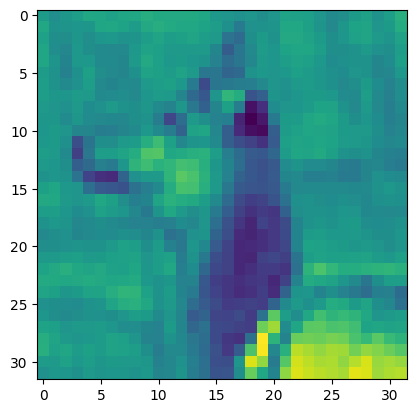

In [120]:
# Illustrate one of the examples
img = torchvision.transforms.functional.rgb_to_grayscale(data[0][3], num_output_channels=1)
style.use('default')
plt.imshow(img.view(32, 32))
plt.plot()
print(classes[int(data[1][3])])

In [166]:
# Create our model (CNN)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        x = torch.randn(3, 32,32).view(-1,3,32,32) # Generate a sample input to compte the inputs' shapes for fc1 layer
        self.to_linear = None
        self.convolutional_pool(x)

        self.fc1 = nn.Linear(self.to_linear, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def convolutional_pool(self, x):
      x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
      x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
      x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
      if self.to_linear is None: # We flatten x to see the shape of inputs of the fc1 layer
        self.to_linear = len(torch.flatten(x))
      return x

    def forward(self, x):
      x = self.convolutional_pool(x)
      x = x.view(-1, self.to_linear)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.log_softmax(self.fc3(x), dim=1)
      return x

net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [163]:
# Feedforward phase, if train is on, backward the loss to update model's weights
# If you run on CPU, omit to.(device)
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)

def feedforward(X, Y, train):
  if train:
    # zero the parameter gradients
    net.zero_grad() 
  # Forward: Compute output
  outputs = net(X)
  # Calculating accuracy
  correct = 0
  for k in range(len(Y)):
    if int(torch.argmax(outputs[k])) == int(Y[k]):
      correct += 1
  acc = correct/len(Y)
  # Compute Loss of the model
  loss = F.cross_entropy(outputs, Y)
  if train:
    # Backward: Change the weights of the model using computed loss
    loss.backward()
    optimizer.step()
  return acc, loss

Epoch 1:


782it [00:25, 30.75it/s]


Epoch 2:


782it [00:25, 30.80it/s]


Epoch 3:


782it [00:25, 30.81it/s]


Epoch 4:


782it [00:25, 30.52it/s]


Epoch 5:


782it [00:25, 30.80it/s]


Epoch 6:


782it [00:25, 30.52it/s]


Epoch 7:


782it [00:25, 30.38it/s]


Epoch 8:


782it [00:25, 30.18it/s]


Epoch 9:


782it [00:25, 30.90it/s]


Epoch 10:


782it [00:25, 30.87it/s]


Epoch 11:


782it [00:25, 30.99it/s]


Epoch 12:


782it [00:25, 30.57it/s]


Epoch 13:


782it [00:25, 30.30it/s]


Epoch 14:


782it [00:25, 30.15it/s]


Epoch 15:


782it [00:25, 30.25it/s]


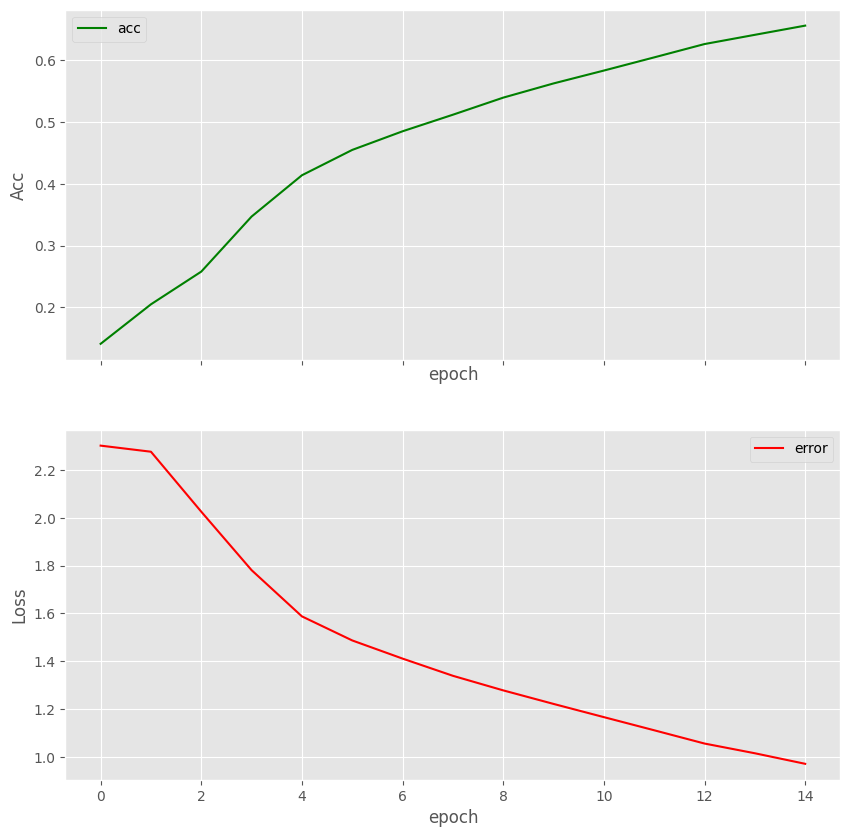

In [164]:
# Train the model and see the performances on Trainset
def train():
  iter =  15
  # Saving accuracies and errors for visualization
  error, accuracy = [], []
  for epoch in range(iter):
    print(f"Epoch {epoch+1}:")
    Global_Error, Global_Accuracy = 0, 0
    for i, data in tqdm(enumerate(trainset)):
      # Reading data  (remember batch = 64)
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # Calling feedforward function
      acc, loss = feedforward(inputs, labels, True)
      Global_Accuracy += round(float(acc), 4)
      Global_Error += loss
    # Computing the means of Loss/Accuracy of each epoch
    accuracy.append(Global_Accuracy / len(trainset))
    error.append(Global_Error / len(trainset))
  
  # Visualization
  style.use('ggplot')
  fig, (ax1, ax2) = plt.subplots(2, sharex = True)
  fig.set_size_inches(10, 10)
  
  ax1.plot(np.arange(iter), accuracy, 'g', label="acc")
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('Acc')
  ax1.legend()

  ax2.plot(np.arange(iter), error, 'r', label="error")
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('Loss')
  ax2.legend()
  
  plt.show()
train()

In [165]:
# See the performance of the model on Testset
def test_model():
  Test_Error, Test_Accuracy = 0, 0
  with torch.no_grad():
    for i in testset:
      inputs, labels = i
      inputs = inputs.to(device)
      labels = labels.to(device)
      val_acc, val_loss = feedforward(inputs, labels, False)
      Test_Accuracy += val_acc
      Test_Error += val_loss

    print(f"Test_Accuracy = {Test_Accuracy/len(testset)}, Test_Loss = {Test_Error/len(testset)}")

test_model()

Test_Accuracy = 0.6563495222929936, Test_Loss = 0.9756606817245483
